# Free Spoken Digit Dataset

In [1]:
import os

data_path = os.path.abspath('') + '/data'
dev_data_path = data_path + '/dev'

In [2]:
from scipy.io import wavfile

data = []
fs = 8e3
y = []

for file_name in os.listdir(dev_data_path):
    data.append(wavfile.read(os.path.join(dev_data_path,file_name))[1])
    y.append(file_name.split('.')[0].split('_')[1])
    
print(len(data))
print(y[:10])

1500
['4', '2', '4', '4', '5', '8', '4', '8', '0', '3']


In [3]:
from spafe.features.gfcc import gfcc
from spafe.utils import vis

sig = data[5]
gfccs = gfcc(sig, fs=fs, num_ceps=13)

vis.spectogram(sig, fs)
vis.visualize_features(gfccs, 'GFCC Index', 'Frame Index')

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [4]:
gfccs

array([[ 4.62033222e-01, -3.15646855e-01, -1.46229755e+00,
         1.02095503e+00,  4.91497342e-01, -3.85737351e-01,
        -1.38251402e+00,  9.22835402e-01,  1.03268880e+00,
        -1.51822321e+00,  5.53902029e-01,  2.05876372e-01,
         6.41753597e-01],
       [ 8.84884165e-01, -7.81698910e-01, -1.85999809e+00,
         7.26476104e-01,  1.21965146e+00, -9.58155916e-01,
        -1.80094879e+00,  1.28420801e+00,  1.50462393e+00,
        -2.37120083e+00,  5.46632840e-01,  1.07754896e+00,
         8.77267573e-01],
       [ 1.17103549e+00, -1.25070406e+00, -1.77420252e+00,
         4.41720947e-01,  9.58965430e-01, -7.16754060e-01,
        -2.03821062e+00,  1.17395067e+00,  1.61666512e+00,
        -2.55559161e+00,  1.33995551e+00,  7.31018611e-01,
         9.94256046e-01],
       [ 1.32436748e+00, -1.35670205e+00, -1.73468391e+00,
         1.24027934e-01,  1.02497512e+00, -6.54197527e-01,
        -2.09106934e+00,  1.14911842e+00,  1.65280930e+00,
        -2.52506874e+00,  1.16787531e

In [5]:
import numpy as np
lengths = list(map(lambda x: x.size, data))
print(f'length interval: {max(lengths)}, {min(lengths)}')

length interval: 17567, 1148


In [6]:
from audio_preprocessing import pad_to_dense
X = pad_to_dense(data)

X

array([[  -5.,  -10.,   -9., ...,    0.,    0.,    0.],
       [   0., -256.,    0., ...,    0.,    0.,    0.],
       [   7.,    6.,    6., ...,    0.,    0.,    0.],
       ...,
       [  -6.,   -1.,    0., ...,    0.,    0.,    0.],
       [  10.,   -9.,   -2., ...,    0.,    0.,    0.],
       [   4.,    3.,    2., ...,    0.,    0.,    0.]])

In [7]:
# Normalization between 0 and 1

X /= np.max(np.abs(X), axis=1)[:, np.newaxis]

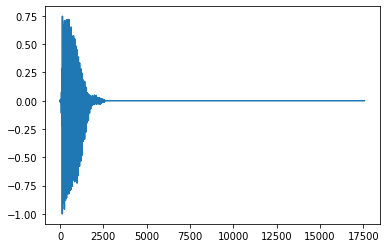

In [8]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.plot(np.arange(X[2].size), X[2])
plt.show()



In [9]:
# cut files longer than T = 8000 (since sampling is at 8kHz)
# shorter files are 0 padded
T = 2 ** 13

X = X[:, :T]

/home/toyo/Programs/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


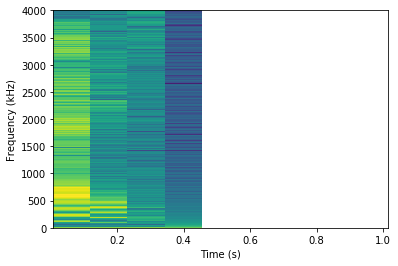

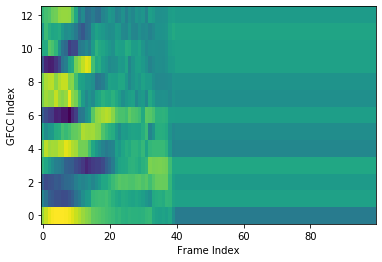

In [10]:
num_ceps = 13

sig = X[5]
gfccs = gfcc(sig, fs=fs, num_ceps=num_ceps)

vis.spectogram(sig, fs)
vis.visualize_features(gfccs, 'GFCC Index', 'Frame Index')

In [11]:
X_train = np.zeros((X.shape[0], gfccs.size))

for i in range(X.shape[0]):
    X_train[i, :] = gfcc(X[i, :], fs=fs, num_ceps=num_ceps).flatten()

In [12]:
X_train.shape

(1500, 1300)

## Model training
Let's try with k-Nearest Neighbors algorithm

In [17]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan')

In [18]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)

In [19]:
from sklearn.pipeline import make_pipeline

pl = make_pipeline(svd, knn)
pl.fit(X_train, y)


Pipeline(memory=None,
         steps=[('truncatedsvd',
                 TruncatedSVD(algorithm='randomized', n_components=100,
                              n_iter=5, random_state=None, tol=0.0)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='manhattan', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='distance'))],
         verbose=False)

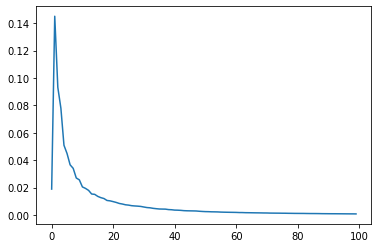

In [22]:
plt.plot(svd.explained_variance_ratio_)

## Test set prediction

In [16]:
eval_data_path = data_path + '/eval'

indices = []
test_data = []

for file_name in os.listdir(eval_data_path):
    indices.append(file_name.split('.')[0])
    test_data.append(wavfile.read(os.path.join(eval_data_path, file_name))[1])

In [17]:
from audio_preprocessing import transform

X_test = transform(test_data)

gfcc size: 1300
Shape of X (500, 1300)


In [18]:
pl.predict(X_test)
y_hat = knn.predict(X_test)

In [19]:
from dump_util import dump_to_file

output_dir = '/home/toyo/PycharmProjects/lab07/output/'
output_filename = os.path.join(output_dir, 'knn_svd_output.csv')

dump_to_file(indices, y_hat, output_filename)
